# Order parameters

## Graph structure

All edges are stored in a list of sets $edgelist$ such that each of them has a label corresponding to its position. At the same position in the list $X$ are stored the order parameters into a list of $8$ elements. Test: $X$ is now a dictionary

1) ring participation
Two integers: 0 if no ring, number of ring members if a closed ring
(0, 4,5,6,7... 12)

2) Other rings that p1, and p2 are a part of: 1 integer for p1, 1 for p2. Since there is only up to one extra ring per particle

3) number of bonded neighbors of the two particles (p1, p2) involved
Two integers: (1,2,3)

4) Local connectivity parameters
- Average number of bonds per neighbor of p1 and p2. (2 real number)

In [1]:
import numpy as np
#from matplotlib import *
from matplotlib import pyplot as plt
from heapq import *
from collections import deque
from collections import defaultdict
import copy

def adjacencyM(N, E):
    G=np.zeros([N, N])
    for e in E:
        G[int(e[0]), int(e[1])] =1
    return G

def rescale(x, M):
    if x>M/2:
        return rescale(x-M, M)
    elif x<-M/2:
        return rescale(x+M, M)
    else:
        return x
    
        
#G_aM = adjacencyM(N, aev[:,:-1])

In [2]:
def dijkstra(G, s, t):
    f=False
    
    if s == t:
        return (0, deque())
    if s in G[t]:
        G[s].remove(t)
        G[t].remove(s) #to avoid the (s,t) edge
        f=True
        
    S = set()
    q=[(0,s)]
    p=[v for v in range(len(G))]
    D = [float('Inf') for v in range(len(G))]; D[s] = 0
    
    while q:
        (dv, v) = heappop(q)
        #print(v)
        if v not in S:
            S.add(v)
            if v == t:
                if f:
                    G[s].add(t)
                    G[t].add(s)
                return (D[t], getpath(p,s,t))
            #print(G[v])
            for u in G[v]:
                if u in S: continue
                d=dv+1
                if D[u] > d:
                    D[u] = d
                    p[u]=v
                    heappush(q, (d, u))
                    #print(">>"+ str(q))
                    
    if f:
        G[s].add(t)
        G[t].add(s)
    return (-1, deque())


def getpath(p, s, t):
    v=t
    path=deque([t])
    while v!=s:
        v=p[v]
        path.appendleft(v)
    return path

In [3]:
l = 0
N=484
C=[]
with open("test.patch", "r") as snap:   #particle positions
    for line in snap:
        if l==0:
            N = int(line[1:])
            l=l+1
        elif l==1:
            tmp=[x for x in line.split()]
            xsize, ysize = float(tmp[0]), float(tmp[1])
            l=l+1
        else:
            tmp=[x for x in line.split()]
            #C.append([rescale(float(tmp[1]), xsize), rescale(float(tmp[2]), ysize)])
            C.append([float(tmp[1]), float(tmp[2])])
            
l = 0
events=[]
with open("breaklist_80.500.dat", "r") as file:  #Breaking Times
    for line in file:
        if l==0:
            l=l+1
        elif l==1:
            tmp=[x for x in line.split()]
            time = float(tmp[-1])
            l=l+1
        else:
            tmp=[x for x in line.split()]
            events.append([int(tmp[0]), int(tmp[1]), float(tmp[3])])

events=np.array(events)
C=np.array(C)

In [39]:
G=[set() for i in range(N)]
edgelist=deque()
y=[]
#X={}

for evs in events:
    ev = evs[:-1]
    edgelist.append(set(ev))
    G[int(ev[0])].add(int(ev[1]))
    G[int(ev[1])].add(int(ev[0]))
    y.append(evs[-1])
    
X = np.array([-1*np.ones(8) for i in range(len(edgelist))])
#X = np.array([-1*np.ones(5) for i in range(len(edgelist))])
y = time/np.array(y)
m = np.mean(y)
std = np.std(y)
y=(((y-m)/std)+1)/2

In [40]:
for i in range(N):
    avg = 0
    if len(G[i]) == 0: continue
    for j in G[i]:
        e_idx = edgelist.index({i,j}) 
        if X[e_idx][0] != -1: continue
        
        r1,p1 =dijkstra(G, i, j)                                                 #finds 1.1

        r1 += 1
        if r1 != 0:
            EXTRAp=[(float("Inf"), deque())]
            for k in range(len(p1)-1):
                G[p1[k]].remove(p1[k+1]); G[p1[k+1]].remove(p1[k])
                EXTRAp.append(dijkstra(G, i, j))
                G[p1[k]].add(p1[k+1]); G[p1[k+1]].add(p1[k])                     #finds 1.2
                
            r2_id=np.argmin([EXTRAp[k][0] for k in range(len(EXTRAp)) if EXTRAp[k][0]!=-1])
            
            r2, p2 = EXTRAp[r2_id]
            r2 += 1
            if r2==float('Inf'): r2 = 0
                
            if r2 != 0:
                G[p1[1]].remove(i); G[i].remove(p1[1])
                G[p1[-2]].remove(j); G[j].remove(p1[-2])
                G[p2[1]].discard(i); G[i].discard(p2[1])
                G[p2[-2]].discard(j); G[j].discard(p2[-2])
                
                r3=dijkstra(G, p1[1], p2[1])[0] + 2
                r4=dijkstra(G, p1[-2], p2[-2])[0] + 2
                
                G[p1[1]].add(i); G[i].add(p1[1])
                G[p1[-2]].add(j); G[j].add(p1[-2])
                G[p2[1]].add(i); G[i].add(p2[1])
                G[p2[-2]].add(j); G[j].add(p2[-2])
            else:
                r3, r4 = 0,0
            
        else:
            r2, r3, r4 = 0,0,0
            
        X[e_idx][0:4] = np.array([r1, r2, r3, r4])
        X[e_idx][4:6] = np.array([len(G[i]), len(G[j])])
        avg += len(G[j])
        
    avg /= len(G[i])                                                             #finds 3
    
    for j in G[i]:
        idx= 7 if i>j else 6
        X[edgelist.index({i,j})][idx] = avg                                      #finds 4

In [17]:
# for 5 O. P.s
for i in range(N):
    avg = 0
    if len(G[i]) == 0: continue
    for j in G[i]:
        e_idx = edgelist.index({i,j}) 
        if X[e_idx][0] != -1: continue
        
        r1,p1 =dijkstra(G, i, j)                                                 #finds 1.1
            
        X[e_idx][0] = r1
        X[e_idx][1:3] = np.array([len(G[i]), len(G[j])])
        avg += len(G[j])
        
    avg /= len(G[i])                                                             #finds 3
    
    for j in G[i]:
        idx= 4 if i>j else 3
        X[edgelist.index({i,j})][idx] = avg                                      #finds 4

In [5]:
#BKU ALGORITHM

for i in range(N):
    avg = 0
    if len(G[i]) == 0: continue
    for j in G[i]:
        e_idx = edgelist.index({i,j}) 
        if X[e_idx][0] != -1: continue
        
        r1,p1 =dijkstra(G, i, j)                                                 #finds 1.1

        r1 += 1
        if r1 != 0:
            G[p1[1]].remove(i); G[i].remove(p1[1])
            G[p1[-2]].remove(j); G[j].remove(p1[-2])
            
            r2, p2 =dijkstra(G, i, j)                                            #finds 1.2
            r2 +=1
            
            if r2 != 0:
                G[p2[1]].remove(i); G[i].remove(p2[1])
                G[p2[-2]].remove(j); G[j].remove(p2[-2])
                
                r3=dijkstra(G, p1[1], p2[1])[0] + 2
                r4=dijkstra(G, p1[-2], p2[-2])[0] + 2
                
                G[p2[1]].add(i); G[i].add(p2[1])
                G[p2[-2]].add(j); G[j].add(p2[-2])
            else:
                r3, r4 = 0,0
            
            G[p1[1]].add(i); G[i].add(p1[1])
            G[p1[-2]].add(j); G[j].add(p1[-2])
            
        else:
            r2, r3, r4 = 0,0,0
            
        X[e_idx][0:4] = np.array([r1, r2, r3, r4])
        X[e_idx][4:6] = np.array([len(G[i]), len(G[j])])
        avg += len(G[j])
        
    avg /= len(G[i])                                                             #finds 3
    
    for j in G[i]:
        idx= 7 if i>j else 6
        X[edgelist.index({i,j})][idx] = avg                                      #finds 4

# Learning parameters

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)


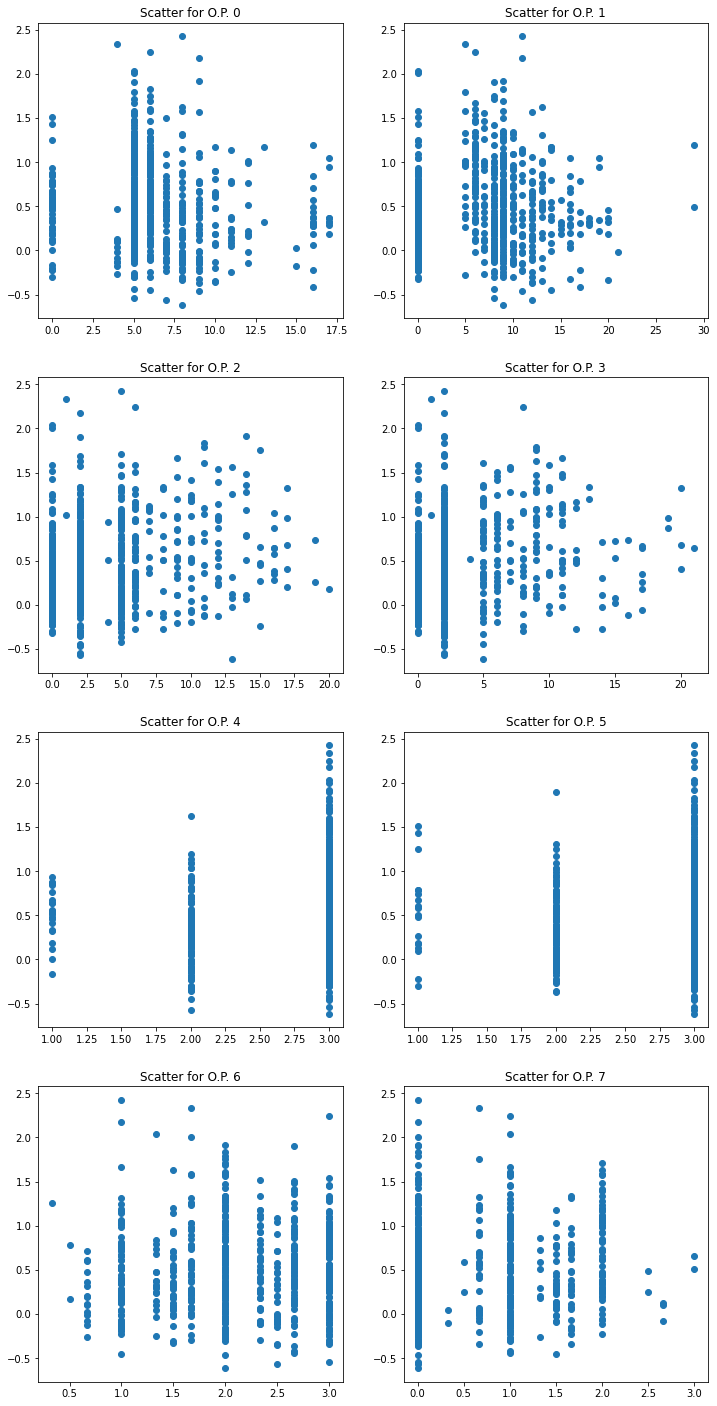

In [47]:
fig, axes = plt.subplots(4, 2, figsize=(12,25))
for i in range(4):
    for j in range(2):
        axes[i][j].set_title("Scatter for O.P. %i"%(2*i+j))
        axes[i][j].scatter(X[:,2*i+j],y)
plt.show()